In [346]:
# Read libraries and data
import torch
import pandas as pd
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [347]:
#Dictionary to convert from index to character
alphabet = sorted(set("".join(words)))
itos = {idx:ch for idx,ch in enumerate(alphabet)}
stoi = {ch:idx for idx,ch in enumerate(alphabet)}

itos[26] = '.'
stoi['.'] = 26

In [348]:
#Creating the dataset
block_size = 3
context = []
X , Y = [], []
for w in words: 

    context = block_size * [0] 

    for i in w + '.':
        idx = stoi[i]
        X.append(context)
        Y.append(idx)
        #print(f"{context} -> {i}")
        context = context[1:] + [idx]
    #print("-----------------")

X = torch.tensor(X)    
Y = torch.tensor(Y)    

In [349]:
#Create train, validation and test dataset
n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = torch.tensor_split(X, (n1, n2), dim=0)
Ytr, Ydev, Yts = torch.tensor_split(Y, (n1, n2), dim=0)

In [418]:
#Define the model variables W1, W2, b1, b2, C, parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g, requires_grad=True)
C_copy = C.clone()
W1 = torch.randn((30,300), generator = g, requires_grad = True)
b1 = torch.randn(300, generator = g, requires_grad=True)
W2 = torch.randn((300,27), generator = g, requires_grad = True)
b2 = torch.randn(27, generator = g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [419]:
# Setting parameters loops , learning rate 
loop = 200000    #Number of iterations
lre = torch.linspace(-3, 0, steps=loop)
lrs = 10**lre
lossi = []
gradi = []
steps = []

In [420]:
for i in range(loop):

    #batches
    idx = torch.randint(0, Xtr.shape[0], (32,))

    #Forward
    #Embedding the input
    emb = C[Xtr[idx]]
    #multiplying the embedding matrix by the first weight matrix
    #I applied view to make the matrix multiplication possible
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    #Multiply the second layer
    logits = h @ W2 + b2

    #Softmax
    #counts = logits.exp()
    #normalization
    #prob = counts / counts.sum(1, keepdim = True)
    #loss
    #loss = -prob[torch.arange(32), Y].log().mean()

    loss = F.cross_entropy(logits,Ytr[idx])

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update the parameters
    loops1 = loop * 0.1
    loops2 = loop * 0.5
    if i < loops1:
        lr = 0.1
    elif (i > loops1) & (i < loops2):
        lr = 0.05
    elif i > loops2:
        lr = 0.01    

    for p in parameters:
        p.data -= p.grad * lr

    if i % 1000 == 0:    
        gradi.append(lr)
        lossi.append(loss.item())
        steps.append(i) 

#Create a dataframe with the results
df = pd.DataFrame({'Steps': steps, 'Learning Rate': gradi, 'Loss': lossi})

print(loss)

tensor(2.1122, grad_fn=<NllLossBackward0>)


In [421]:
df.head(50)

,Steps,Learning Rate,Loss
0,0,0.10,41.692745
1,1000,0.10,4.721642
2,2000,0.10,3.883883
3,3000,0.10,3.074221
4,4000,0.10,3.779105
5,5000,0.10,3.495600
6,6000,0.10,2.257595
7,7000,0.10,3.504112
8,8000,0.10,2.310634
9,9000,0.10,2.947043


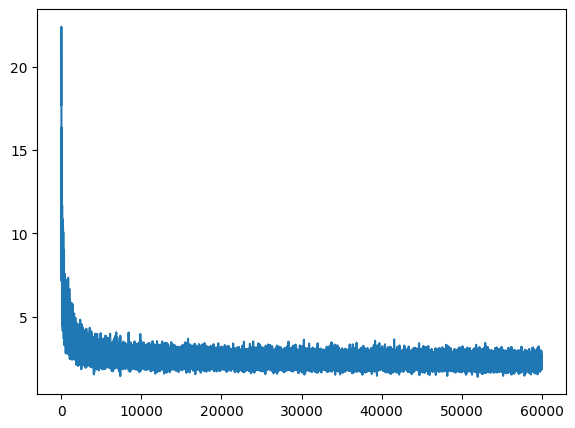

In [353]:
#Graph parameters gradient and steps
fig = plt.figure(figsize=(15, 5))

#ax1 = fig.add_subplot(1, 2, 1)
#plt.plot(gradi, lossi)  # Remove the 'ax' argument here

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(steps, lossi)  # Remove the 'ax' argument here


In [422]:
#Running in the training set
#Forward
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
#Multiply the second layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
print(loss)

tensor(2.1176, grad_fn=<NllLossBackward0>)


In [423]:
#Running in the validation set
#Forward
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
#Multiply the second layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print(loss)

tensor(2.4400, grad_fn=<NllLossBackward0>)


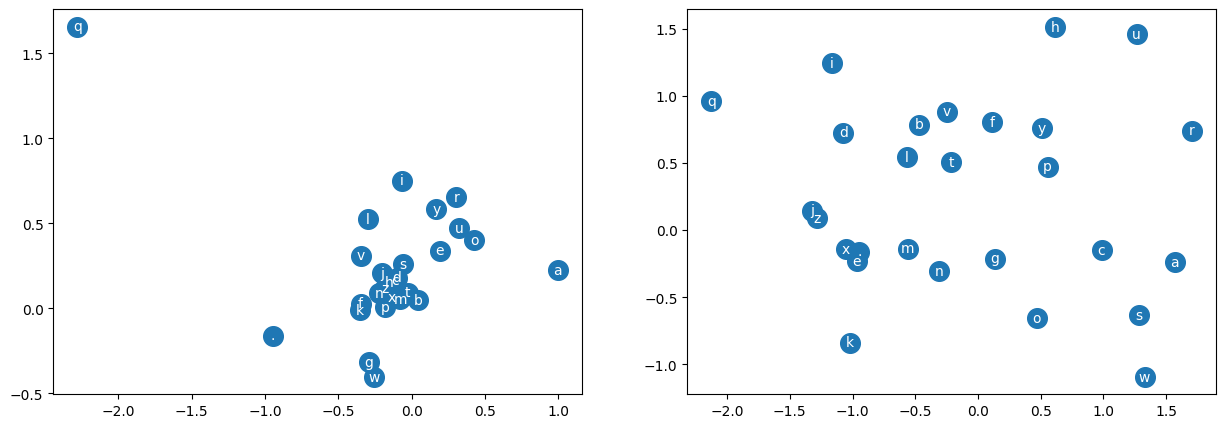

In [356]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(27):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha= 'center', va= 'center', color = 'white')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(C_copy[:,0].data, C_copy[:,1].data, s = 200)
for i in range(27):
    plt.text(C_copy[i,0].item(), C_copy[i,1].item(), itos[i], ha= 'center', va= 'center', color = 'white')    

In [416]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    context = block_size * [0]
    
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim = 1)
        idx = torch.multinomial(prob, num_samples = 1, generator = g).item()
        context = context[1:] + [idx]
        out.append(idx)

        if idx == 0:
            break
    
    print("".join([itos[i] for i in out]))

ka
poene.hndre.hnt.hrphilona
a
kins.on.unce.hn.uley.hnty.hntyn.ir.h.hntinn.hnte.hnkoron.unce.hnosten.iro.ha
nna
a
da
zot.hjra
kylea
da
